In [1]:
import numpy as np
import numba as nb
import pylab as plt

njit = nb.njit
np.random.seed(0)

In [2]:
W0 = 1            # For easier computations - results are linear anyway in W0
r = 0.005         # taux livret A
m = 0.0463        # From get-mean-std-CAC40-after-outbreak.py output
sigma = 0.0313    # From get-mean-std-CAC40-after-outbreak.py output
S = 10000         # Number of Monte-Carlo simulations

In [3]:
@njit(nogil=True)
def compute_mu(m, sigma, S, set_seed = True):
    if set_seed: np.random.seed(0)
    mu = np.empty(S)
    for s in np.arange(S):
        mu[s] = m + sigma*np.random.normal()
    return mu

In [4]:
@njit(nogil = True)
def compute_actualized_wealth(W0, r, mu, phi, c):
    S, = mu.shape
    W = np.zeros(S)
    for s in np.arange(S):
        W[s] = np.maximum(0, W0 + (mu[s] - r)*np.minimum(phi, W0 - c)/(1 + r) - c)
    return W

def compute_actualized_wealth_np(W0, r, mu, phi, c):
    return np.maximum(0, W0 + (mu - r)*np.minimum(phi, W0 - c)/(1 + r) - c)

c = 0.1
phi = 0.9
S = 1000
mu = compute_mu(m, sigma, S)

%time W1 = compute_actualized_wealth(W0, r, mu, phi, c)
%time W2 = compute_actualized_wealth_np(W0, r, mu, phi, c)

assert (W1 == W2).sum() == S

Wall time: 156 ms
Wall time: 0 ns


In [5]:
@njit(nogil = True)
def compute_probability(W_lim, W, phi, c):
    S_lim = 0
    S = W.shape[0]
    for s in np.arange(S):
        W_s = W[s]
        if W_s <= W_lim:
            S_lim += 1
    return S_lim/S

c = 0.5
phi = .6
S = 10000000
mu = compute_mu(m, sigma, S)
W = compute_actualized_wealth(W0, r, mu, phi, c)

%time compute_probability(W0/2, W, phi, .5)

Wall time: 187 ms


0.0934152

In [12]:
S = 10000
N_phi = 1000
N_c = 100

@njit(nogil = True)
def compute_phi_star(W0, r, m, sigma, S, N_phi = 100, N_c = 100, alpha = 0.05):
    mu = compute_mu(m, sigma, S)
    W0_over_N_phi = W0/N_phi
    c_over_N_c = W0/N_c
    phi_star = np.nan*np.ones(N_c + 1)
    for n_c in np.arange(N_c + 1):
        c = c_over_N_c*n_c
        p = 0
        for n_phi in np.arange(N_phi + 1):
            phi = W0_over_N_phi*n_phi
            if phi > W0 - c: continue
            W = compute_actualized_wealth(W0, r, mu, phi, c)
            p = compute_probability(W0/2, W, phi, c)
            if p < alpha:
                phi_star[n_c] = phi
    return phi_star

%time phi_star = compute_phi_star(W0, r, m, sigma, S, N_phi = N_phi, N_c = N_c)

Wall time: 2.41 s


1.0

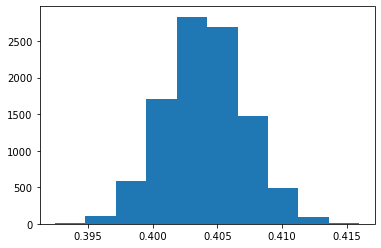

In [36]:
mu = compute_mu(m, sigma, S)
W0_over_N_phi = W0/N_phi
c_over_N_c = W0/N_c
phi_star = np.nan*np.ones(N_c + 1)
c = .6
p = 0
phi = 0.1
W = compute_actualized_wealth(W0, r, mu, phi, c)
plt.hist(W)
p = compute_probability(W0/2, W, phi, c)
p

0.0

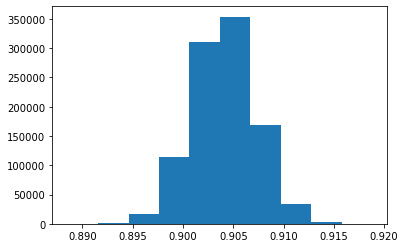

In [47]:
S = 1000000
mu = compute_mu(m, sigma, S)
W0_over_N_phi = W0/N_phi
c_over_N_c = W0/N_c
phi_star = np.nan*np.ones(N_c + 1)
c = .1
p = 0
phi = 0.1
W = compute_actualized_wealth(W0, r, mu, phi, c)
plt.hist(W)
p = compute_probability(W0/2, W, phi, c)
p